In [45]:
import json
import numpy
from collections import defaultdict
import matplotlib.pyplot as plt
#from matplotlib.pyplot import imshow
import pandas as pd
import numpy as np
import os
from PIL import Image, ImageOps, ImageEnhance
#from PIL import ImageOps
%matplotlib inline

In [2]:
from gluoncv import model_zoo, data, utils
import random
import sys
import cv2

from data_aug.data_aug import *
from data_aug.bbox_util import *

In [3]:
inst_train_path = "/home/ubuntu/data/annotations/instances_train2017.json"
inst_train  = json.loads(open(inst_train_path).read())
inst_train.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [4]:
captions_train_path = "/home/ubuntu/data/annotations/captions_train2017.json"
captions_val_path = "/home/ubuntu/data/annotations/captions_val2017.json"
inst_train_path = "/home/ubuntu/data/annotations/instances_train2017.json"
inst_val_path = "/home/ubuntu/data/annotations/instances_val2017.json"

In [5]:
def merge_image_info(captions_path, inst_path):
    captions  = json.loads(open(captions_path).read())
    inst  = json.loads(open(inst_path).read())
    image_df = pd.DataFrame(inst['images'])
    annotation_df = pd.DataFrame(inst['annotations'])
    #the 'id' in image_df needs to be changed to 'image_id' in order to join with annotations_df
    renamed_image_df = image_df.copy(deep=True)
    renamed_image_df.rename(columns={'id':'image_id'}, inplace=True)
    images_and_annotations_df = annotation_df.merge(renamed_image_df,on='image_id', how='left')
    #electronics_only_merged_df = images_and_annotations_df.loc[(images_and_annotations_df['category_id'] >= 72) & (images_and_annotations_df['category_id'] <= 77)]
    
    #select all images that contain electronics
    #all_images_with_electronics = list(pd.Series(electronics_only_merged_df['image_id']).unique())
    
    #return(electronics_only_merged_df)
    return(images_and_annotations_df)

In [6]:
def write_line(img_path, im_shape, boxes, ids, idx):
    h, w, c = im_shape
    # for header, we use minimal length 2, plus width and height
    # with A: 4, B: 5, C: width, D: height
    A = 4
    B = 5
    C = w
    D = h
    # concat id and bboxes
    labels = np.hstack((ids.reshape(-1, 1), boxes)).astype('float')
    # normalized bboxes (recommanded)
    labels[:, (1, 3)] /= float(w)
    labels[:, (2, 4)] /= float(h)
    # flatten
    labels = labels.flatten().tolist()
    str_idx = [str(idx)]
    str_header = [str(x) for x in [A, B, C, D]]
    str_labels = [str(x) for x in labels]
    str_path = [img_path]
    line = '\t'.join(str_idx + str_header + str_labels + str_path) + '\n'
    return line

In [7]:
train_info = merge_image_info(captions_train_path, inst_train_path)
val_info = merge_image_info(captions_val_path, inst_val_path)

In [8]:
train_info.head()#add in actual label name

,area,bbox,category_id,id,image_id,iscrowd,segmentation,coco_url,date_captured,file_name,flickr_url,height,license,width
0,2765.14865,"[199.84, 200.46, 77.71, 70.88]",58,156,558840,0,"[[239.97, 260.24, 222.04, 270.49, 199.84, 253....",http://images.cocodataset.org/train2017/000000...,2013-11-15 06:55:40,000000558840.jpg,http://farm5.staticflickr.com/4045/4488509035_...,427,1,640
1,1545.42130,"[234.22, 317.11, 149.39, 38.55]",58,509,200365,0,"[[247.71, 354.7, 253.49, 346.99, 276.63, 337.3...",http://images.cocodataset.org/train2017/000000...,2013-11-15 00:04:50,000000200365.jpg,http://farm2.staticflickr.com/1177/1162747961_...,480,3,640
2,5607.66135,"[239.48, 347.87, 160.0, 57.81]",58,603,200365,0,"[[274.58, 405.68, 298.32, 405.68, 302.45, 402....",http://images.cocodataset.org/train2017/000000...,2013-11-15 00:04:50,000000200365.jpg,http://farm2.staticflickr.com/1177/1162747961_...,480,3,640
3,0.00000,"[296.65, 388.33, 1.03, 0.0]",58,918,200365,0,"[[296.65, 388.33, 296.65, 388.33, 297.68, 388....",http://images.cocodataset.org/train2017/000000...,2013-11-15 00:04:50,000000200365.jpg,http://farm2.staticflickr.com/1177/1162747961_...,480,3,640
4,800.41325,"[251.87, 333.42, 125.94, 22.71]",58,1072,200365,0,"[[251.87, 356.13, 260.13, 343.74, 300.39, 335....",http://images.cocodataset.org/train2017/000000...,2013-11-15 00:04:50,000000200365.jpg,http://farm2.staticflickr.com/1177/1162747961_...,480,3,640


In [9]:
#get list of image_ids
image_list = train_info['image_id'].unique()
list(image_list)[:10]

[558840, 200365, 495357, 116061, 16164, 205350, 74, 212545, 514915, 154589]

In [10]:
test_image_info = train_info[train_info['image_id']==16164]
test_image_info

,area,bbox,category_id,id,image_id,iscrowd,segmentation,coco_url,date_captured,file_name,flickr_url,height,license,width
7,19957.72675,"[324.66, 247.92, 250.87, 181.02]",18,1767,16164,0,"[[392.54, 324.66, 351.22, 324.66, 337.45, 335....",http://images.cocodataset.org/train2017/000000...,2013-11-15 01:17:31,000000016164.jpg,http://farm4.staticflickr.com/3634/3585567454_...,486,3,640
11149,17053.22910,"[0.0, 69.09, 126.84, 169.21]",70,1093636,16164,0,"[[12.66, 195.24, 0.16, 176.27, 0.0, 169.15, 0....",http://images.cocodataset.org/train2017/000000...,2013-11-15 01:17:31,000000016164.jpg,http://farm4.staticflickr.com/3634/3585567454_...,486,3,640


In [16]:
#train_info.loc[0,:]['image_id']

558840

In [11]:
train_folder_name = '/home/ubuntu/data/train2017/'
all_train_filenames = os.listdir(train_folder_name)
max_file_id_length = len(all_train_filenames[0]) - 4

In [19]:
files_to_open = []
for image_id in train_info['image_id']:
    file_id = str(image_id)
    zeros_to_add = max_file_id_length-len(file_id)
    filename = ('0'*zeros_to_add) + file_id + '.jpg'
    files_to_open.append(filename)

In [24]:
file_name = train_folder_name + files_to_open[0]

In [28]:
file_name

'/home/ubuntu/data/train2017/000000558840.jpg'

In [14]:
file_name = train_folder_name + '000000' + str(train_info.loc[0,:]['image_id']) + '.jpg'
file_name

'/home/ubuntu/data/train2017/000000558840.jpg'

In [12]:
file_name = train_folder_name + '000000016164.jpg'
file_name

'/home/ubuntu/data/train2017/000000016164.jpg'

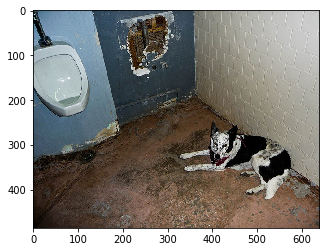

In [35]:
im = Image.open(file_name)
width, height = im.size
#print(width)
#print(height)
#imshow(np.asarray(im))
plt.imshow(im)
plt.show()

In [13]:
original_height = test_image_info['height'].unique()[0]
original_width = test_image_info['width'].unique()[0]
original_dimensions = (original_width, original_height)
#print('original dimensions:', str(original_height), "x", original_width)
#print(type(original_height))
print('original dimensions:', str(original_dimensions))

original dimensions: (640, 486)


In [15]:
#x, img = data.transforms.presets.ssd.load_test(file_name, short=512)
x, img = data.transforms.presets.ssd.load_test(file_name, short=486)
#x, img = data.transforms.presets.ssd.load_test(file_name, short=360)

In [16]:
x.shape

(1, 3, 486, 640)

In [38]:
scaled_dimensions = (x.shape[3],x.shape[2])
scaled_dimensions

(674, 512)

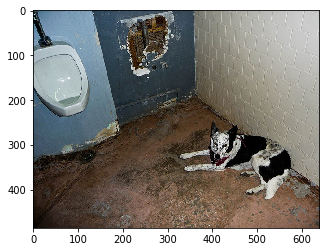

In [17]:
ax = utils.viz.plot_image(img)
plt.show()

In [18]:
test_image_info.index

Int64Index([7, 11149], dtype='int64')

In [19]:
#get bboxes
bboxes = []
for idx in test_image_info.index:
    b_box = test_image_info.loc[idx,:]['bbox'].copy()
    reorder = [0, 1, 2, 3]
    #reorder = [1, 0, 3, 2]
    #reorder = [0, 3, 2, 1]
    #reorder = [3, 2, 1, 0]
    #reorder = [2, 1, 0, 3]
    #reorder = [2, 3, 0, 1]
    #reorder = [3, 2, 1, 0]
    #reorder = [0, 2, 1, 3]
    #reorder = [1, 3, 0, 2]
    #reorder = [3, 1, 2, 0]
    #reorder = [2, 0, 3, 1]
    #reorder = [0, 2, 1, 3]
    #reorder = [0, 2, 3, 1]
    #reorder = [2, 0, 1, 3]
    #reorder = [2, 1, 3, 0]
    b_box = [b_box[i] for i in reorder]
    b_box_class = test_image_info.loc[idx,:]['category_id']
    #if b_box_class == 58:
        #b_box.append(b_box_class)
        #bboxes.append(np.array(b_box))
    b_box.append(b_box_class)
    bboxes.append(np.array(b_box))
    #print(test_image_info.loc[idx,:])
bboxes = np.array(bboxes)
bboxes

array([[324.66, 247.92, 250.87, 181.02,  18.  ],
       [  0.  ,  69.09, 126.84, 169.21,  70.  ]])

In [20]:
#get bboxes
bboxes2 = []
for idx in test_image_info.index:
    b_box = test_image_info.loc[idx,:]['bbox'].copy()
    #b_box_class = test_image_info.loc[idx,:]['category_id']
    #b_box.append(b_box_class)
    reorder = [0, 1, 2, 3]
    bboxes2.append(np.array(b_box))
    #print(test_image_info.loc[idx,:])
bboxes2 = np.array(bboxes2)
bboxes2

array([[324.66, 247.92, 250.87, 181.02],
       [  0.  ,  69.09, 126.84, 169.21]])

In [39]:
scaled_bboxes = data.transforms.bbox.resize(bboxes2, in_size=original_dimensions, out_size=scaled_dimensions)
scaled_bboxes

array([[341.9075625 , 261.18320988, 264.19746875, 190.70419753],
       [  0.        ,  72.78617284, 133.578375  , 178.26238683]])

In [18]:
#b_box_test = train_info.loc[0,:]['bbox'].copy()
#b_box_test

[199.84, 200.46, 77.71, 70.88]

In [19]:
#bbox_class = train_info.loc[0,:]['category_id']

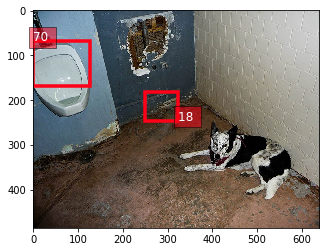

In [21]:
ax = utils.viz.plot_bbox(img, np.array(bboxes2), labels=np.array(test_image_info['category_id']), class_names=['blah']*len(bboxes))
#ax = utils.viz.plot_bbox(img, np.array(bboxes2), labels=np.array(test_image_info['category_id']), class_names=['blah']*len(bboxes), absolute_coordinates=True)
#ax = utils.viz.plot_bbox(img, np.array(scaled_bboxes), labels=np.array(test_image_info['category_id']), class_names=['blah']*len(bboxes))
plt.show()

In [ ]:
#current b_box format: [xmin, ymin, xmax, ymax]
#need to convert bbox format to [top left x, top left y, bottom right x, bottom right y, class]
#want [xmin, ymax, xmax, ymin]

In [22]:
img = cv2.imread(file_name)[:,:,::-1]
#bboxes = np.array([b_box_test])
print(bboxes)

[[324.66 247.92 250.87 181.02  18.  ]
 [  0.    69.09 126.84 169.21  70.  ]]


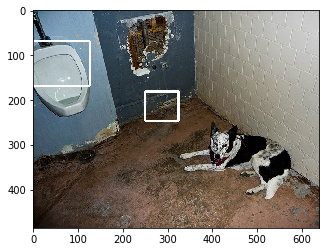

In [23]:
plotted_img = draw_rect(img, bboxes)
plt.imshow(plotted_img)
plt.show()

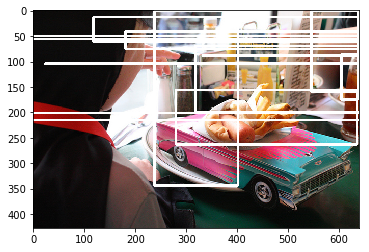

In [42]:
img_, bboxes_ = RandomHorizontalFlip(1)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

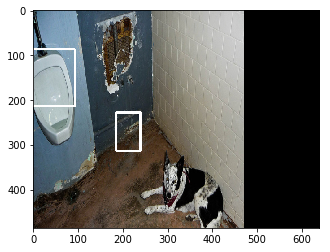

In [24]:
img_, bboxes_ = RandomScale(0.3, diff = True)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

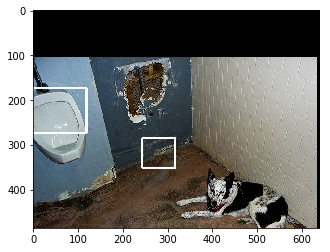

In [25]:
img_, bboxes_ = RandomTranslate(0.3, diff = True)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

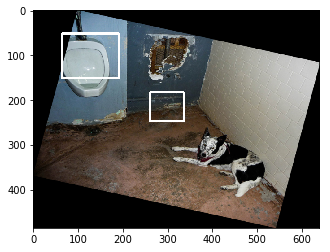

In [26]:
img_, bboxes_ = RandomRotate(20)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

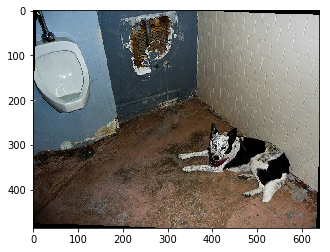

In [41]:
rotated = im.rotate(-2)
plt.imshow(rotated)
plt.show()

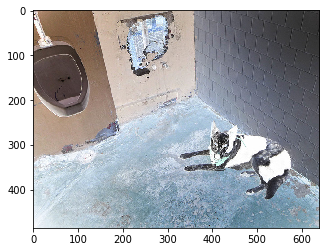

In [44]:
inverted = ImageOps.invert(im)
plt.imshow(inverted)
plt.show()

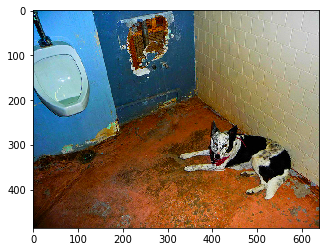

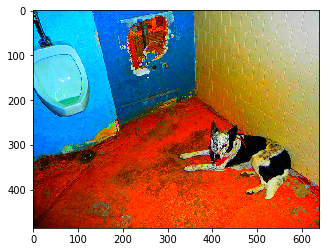

In [56]:
enhancer = ImageEnhance.Color(im)
#for enhancement in [4, 8, 12, 16, 20]:
for enhancement in [3, 8]:
    enhanced_im = enhancer.enhance(enhancement)
    plt.imshow(enhanced_im)
    plt.show()

In [58]:
np.asarray(im).shape

(486, 640, 3)

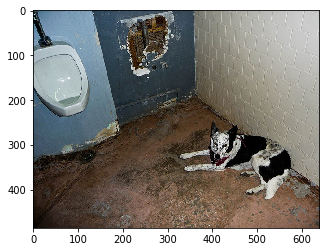

In [59]:
plt.imshow(np.asarray(im))
plt.show()

In [49]:
#cv2.imwrite('/home/ubuntu/data/train2017/augmentations/'+, img_)
img_path = '/home/ubuntu/'+str(558840)+'_aug1.jpg'
cv2.imwrite(img_path, img_)

True

In [50]:
write_line(img_path, img_.shape, bboxes2, np.array(test_image_info['category_id']), 0)

'0\t4\t5\t640\t427\t58.0\t0.31225\t0.46946135831381736\t0.12142187499999998\t0.16599531615925056\t44.0\t0.508234375\t0.24444964871194377\t0.052609375\t0.24822014051522248\t44.0\t0.26382812499999997\t0.21306791569086653\t0.049093750000000005\t0.2077985948477752\t47.0\t0.003\t0.2058782201405152\t0.054609375\t0.41065573770491803\t1.0\t0.54153125\t0.0025058548009367684\t0.456265625\t0.8049414519906323\t44.0\t0.3735625\t0.10004683840749415\t0.0310625\t0.17969555035128806\t50.0\t0.640515625\t0.504496487119438\t0.11225\t0.11737704918032786\t1.0\t0.0015\t0.002388758782201405\t0.1454375\t0.3752927400468384\t44.0\t0.431859375\t0.03234192037470726\t0.049609375\t0.144192037470726\t67.0\t0.005203125\t0.6181733021077283\t0.56146875\t0.36625292740046833\t50.0\t0.64615625\t0.4728337236533958\t0.11373437500000001\t0.1320374707259953\t/home/ubuntu/558840_aug1.jpg\n'

In [51]:
with open('/home/ubuntu/test.lst', 'w') as fw:
    for i in range(1):
        line = write_line(img_path, img_.shape, bboxes2, np.array(test_image_info['category_id']), i)
        print(line)
        fw.write(line)

0	4	5	640	427	58.0	0.31225	0.46946135831381736	0.12142187499999998	0.16599531615925056	44.0	0.508234375	0.24444964871194377	0.052609375	0.24822014051522248	44.0	0.26382812499999997	0.21306791569086653	0.049093750000000005	0.2077985948477752	47.0	0.003	0.2058782201405152	0.054609375	0.41065573770491803	1.0	0.54153125	0.0025058548009367684	0.456265625	0.8049414519906323	44.0	0.3735625	0.10004683840749415	0.0310625	0.17969555035128806	50.0	0.640515625	0.504496487119438	0.11225	0.11737704918032786	1.0	0.0015	0.002388758782201405	0.1454375	0.3752927400468384	44.0	0.431859375	0.03234192037470726	0.049609375	0.144192037470726	67.0	0.005203125	0.6181733021077283	0.56146875	0.36625292740046833	50.0	0.64615625	0.4728337236533958	0.11373437500000001	0.1320374707259953	/home/ubuntu/558840_aug1.jpg



In [53]:
with open('/home/ubuntu/test.lst', 'rb') as fw:
    print(fw.read())

b'0\t4\t5\t640\t427\t58.0\t0.31225\t0.46946135831381736\t0.12142187499999998\t0.16599531615925056\t44.0\t0.508234375\t0.24444964871194377\t0.052609375\t0.24822014051522248\t44.0\t0.26382812499999997\t0.21306791569086653\t0.049093750000000005\t0.2077985948477752\t47.0\t0.003\t0.2058782201405152\t0.054609375\t0.41065573770491803\t1.0\t0.54153125\t0.0025058548009367684\t0.456265625\t0.8049414519906323\t44.0\t0.3735625\t0.10004683840749415\t0.0310625\t0.17969555035128806\t50.0\t0.640515625\t0.504496487119438\t0.11225\t0.11737704918032786\t1.0\t0.0015\t0.002388758782201405\t0.1454375\t0.3752927400468384\t44.0\t0.431859375\t0.03234192037470726\t0.049609375\t0.144192037470726\t67.0\t0.005203125\t0.6181733021077283\t0.56146875\t0.36625292740046833\t50.0\t0.64615625\t0.4728337236533958\t0.11373437500000001\t0.1320374707259953\t/home/ubuntu/558840_aug1.jpg\n'


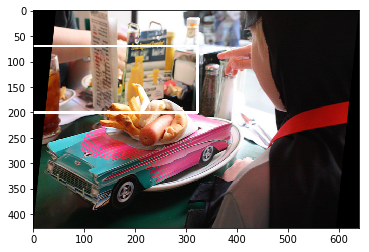

In [57]:
img_, bboxes_ = RandomShear(0.2)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

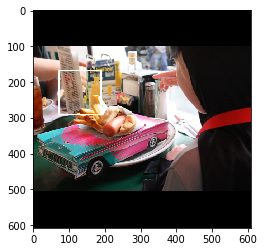

In [58]:
img_, bboxes_ = Resize(608)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

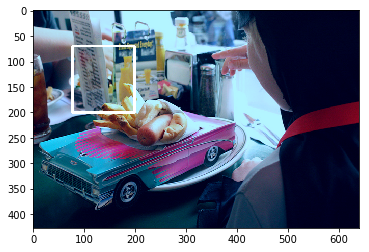

In [59]:
img_, bboxes_ = RandomHSV(100, 100, 100)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

In [62]:
cv2.imwrite('/home/ubuntu/test_save.jpg', img_)

True

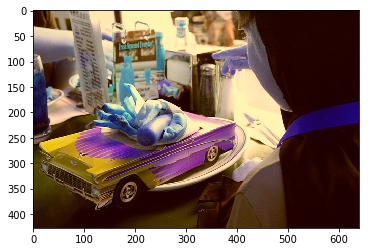

In [63]:
img = cv2.imread('/home/ubuntu/test_save.jpg')[:,:,::-1]
plt.imshow(img)
plt.show()